In [1]:
!nvidia-smi

Wed May 13 10:50:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


In [3]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:18, 44.4MB/s]


'oxford_pet.zip'

In [4]:
## oxford_pet.zip이 보이는지 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 May 13 10:50 oxford_pet.zip
drwxr-xr-x 1 root root      4096 May  4 16:26 sample_data


In [0]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [6]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


In [0]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [8]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [9]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  bbox_file = os.path.splitext(image_file)[0]+'.xml'
  bbox_path = os.path.join(bbox_dir, bbox_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
    try:
      os.remove(bbox_path)
    except FileNotFoundError:
      pass

Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Abyssinian_5.jpg RGBA
(150, 200, 4)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_34.jpg P
(202, 250)
Egyptian_Mau_177.jpg P
(175, 246)


In [10]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [20]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

3685

In [12]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [13]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [14]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [0]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train_xml')
val_dir = os.path.join(data_dir, 'val_xml')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [21]:
bbox_files[:20]

['beagle_109.xml',
 'english_setter_14.xml',
 'samoyed_159.xml',
 'scottish_terrier_190.xml',
 'Bombay_111.xml',
 'Maine_Coon_151.xml',
 'saint_bernard_132.xml',
 'Siamese_113.xml',
 'British_Shorthair_160.xml',
 'British_Shorthair_157.xml',
 'British_Shorthair_199.xml',
 'staffordshire_bull_terrier_117.xml',
 'pomeranian_175.xml',
 'great_pyrenees_112.xml',
 'pomeranian_150.xml',
 'Bengal_128.xml',
 'Maine_Coon_142.xml',
 'Persian_125.xml',
 'Siamese_184.xml',
 'chihuahua_14.xml']

In [0]:
IMG_SIZE = 224
N_BBOX = len(bbox_files)
N_TRAIN = 3000
N_VAL = N_BBOX - N_TRAIN

In [0]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'loc_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'loc_val.tfr')

In [0]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [0]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [44]:
for idx in train_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)
  width = float(tree.find('./size/width').text)
  height = float(tree.find('.size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()

3000


In [45]:
for idx in val_idx_list:
  bbox_file = bbox_files[idx]
  bbox_path = os.path.join(bbox_dir, bbox_file)

  tree = et.parse(bbox_path)
  width = float(tree.find('./size/width').text)
  height = float(tree.find('.size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  file_name = os.path.splitext(bbox_file)[0]
  image_file = file_name + '.jpg'
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1
  
  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(bi_cls_num),
      'x': _float_feature(x),
      'y': _float_feature(y),
      'w': _float_feature(w),
      'h': _float_feature(h)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()

685


In [0]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 30
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [0]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

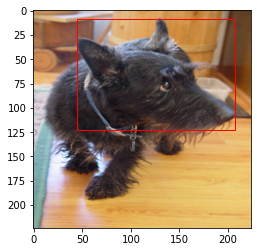

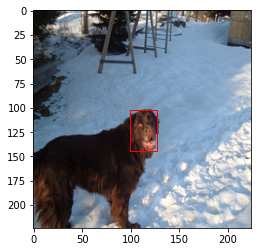

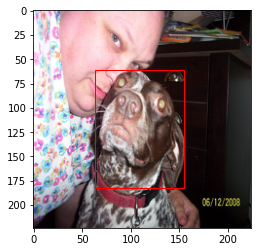

In [194]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(3):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

In [0]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [0]:
## MobileNet V2의 pretrained model을 load
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [197]:
## localization을 위한 network
## mobilenet v2 구조에 fully connected layer 3개를 추가하고 마지막 layer는 4개의 node로 x,y,w,h를 예측하도록 함
model = models.Sequential()
model.add(mobilenetv2)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 256)               327936    
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
re_lu_27 (ReLU)              (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                16448     
_________________________________________________________________
batch_normalization_28 (Batc (None, 64)               

In [0]:
def loss_fn(y_true, y_pred):
  return keras.losses.MeanSquaredError()(y_true, y_pred)+keras.losses.MeanAbsoluteError()(y_true, y_pred)

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss=loss_fn)

In [200]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/30
75/75 [==============================] - 16s 213ms/step - loss: 0.2074 - val_loss: 0.1884
Epoch 2/30
75/75 [==============================] - 15s 205ms/step - loss: 0.1322 - val_loss: 0.1610
Epoch 3/30
75/75 [==============================] - 15s 204ms/step - loss: 0.0956 - val_loss: 0.1412
Epoch 4/30
75/75 [==============================] - 15s 206ms/step - loss: 0.0774 - val_loss: 0.1397
Epoch 5/30
75/75 [==============================] - 15s 204ms/step - loss: 0.0678 - val_loss: 0.1266
Epoch 6/30
75/75 [==============================] - 15s 203ms/step - loss: 0.0623 - val_loss: 0.1267
Epoch 7/30
75/75 [==============================] - 15s 205ms/step - loss: 0.0555 - val_loss: 0.1116
Epoch 8/30
75/75 [==============================] - 15s 205ms/step - loss: 0.0525 - val_loss: 0.0887
Epoch 9/30
75/75 [==============================] - 15s 204ms/step - loss: 0.0500 - val_loss: 0.0934
Epoch 10/30
75/75 [==============================] - 15s 204ms/step - loss: 0.0461 - val_lo

In [201]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()    

Output hidden; open in https://colab.research.google.com to view.

In [202]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    for idx in range(N_BATCH):
      if(flag):
        if idx == res:
          flag = False
          break          
      xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
      ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
      xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
      ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

      pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
      pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
      pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
      pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

      if xmin > pred_xmax or xmax < pred_xmin:        
        continue
      if ymin > pred_ymax or ymax < pred_ymin:        
        continue
      w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
      h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
      w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
      h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

      iou = (w_inter * h_inter) / (w_union * h_union)
      avg_iou += iou / N_VAL

print(avg_iou)

0.5748705788126991


In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.float32)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([bi_cls_label, x, y, w, h], -1)
    
    return image, gt

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [0]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

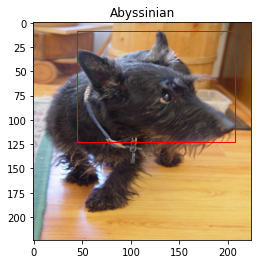

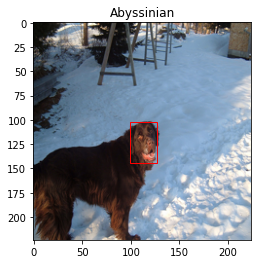

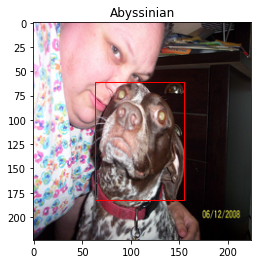

In [206]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(3):
    
    cls = tf.cast(gt[:,0], tf.int64)
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,1]
    y = gt[:,2]
    w = gt[:,3]
    h = gt[:,4]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.title(class_list[cls[0]])
    plt.show()

In [0]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
gap = GlobalAveragePooling2D()(mobilenetv2.output)
dense_b1_1 = Dense(256)(gap)
bn_b1_2 = BatchNormalization()(dense_b1_1)
relu_b1_3 = ReLU()(bn_b1_2)
output1 = Dense(37, activation='softmax')(relu_b1_3)
dense_b2_1 = Dense(256)(gap)
bn_b2_2 = BatchNormalization()(dense_b2_1)
relu_b2_3 = ReLU()(bn_b2_2)
dense_b2_4 = Dense(64)(relu_b2_3)
bn_b2_5 = BatchNormalization()(dense_b2_4)
relu_b2_6 = ReLU()(bn_b2_5)
output2 = Dense(4)(relu_b2_6)
concat = Concatenate()([output1, output2])
model = keras.Model(inputs=mobilenetv2.input, outputs=concat)

In [0]:
#model.summary()

In [0]:
def loss_fn(y_true, y_pred):
  cls_labels = tf.cast(y_true[:,:1], tf.int64)
  loc_labels = y_true[:,1:]
  #print(cls_labels[0], loc_labels[0])
  cls_preds = y_pred[:,:37]
  loc_preds = y_pred[:,37:]
  #print(cls_preds[0], loc_preds[0])
  cls_loss = tf.keras.losses.SparseCategoricalCrossentropy()(cls_labels, cls_preds)
  loc_loss = tf.keras.losses.MeanSquaredError()(loc_labels, loc_preds)
  return cls_loss + loc_loss

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.7,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss=loss_fn)

In [0]:
ckpt_dir_name = 'checkpoints'
checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

In [0]:
ckpt_name = 'loc_{epoch:04d}.ckpt'
checkpoint_path = os.path.join(checkpoint_dir, ckpt_name)

# callback 만들기
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                              save_weights_only=True)

In [270]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS+10,
         validation_data=val_dataset,
         validation_steps=validation_steps,
         callbacks=[cp_callback])

Epoch 1/40
75/75 [==============================] - 16s 220ms/step - loss: 2.4944 - val_loss: 1.3054
Epoch 2/40
75/75 [==============================] - 16s 210ms/step - loss: 0.6989 - val_loss: 0.7742
Epoch 3/40
75/75 [==============================] - 16s 209ms/step - loss: 0.2221 - val_loss: 0.6540
Epoch 4/40
75/75 [==============================] - 16s 209ms/step - loss: 0.0763 - val_loss: 0.2572
Epoch 5/40
75/75 [==============================] - 16s 209ms/step - loss: 0.0371 - val_loss: 0.1116
Epoch 6/40
75/75 [==============================] - 16s 209ms/step - loss: 0.0291 - val_loss: 0.1425
Epoch 7/40
75/75 [==============================] - 16s 210ms/step - loss: 0.0237 - val_loss: 0.0894
Epoch 8/40
75/75 [==============================] - 16s 209ms/step - loss: 0.0140 - val_loss: 0.0961
Epoch 9/40
75/75 [==============================] - 16s 209ms/step - loss: 0.0159 - val_loss: 0.1237
Epoch 10/40
75/75 [==============================] - 16s 210ms/step - loss: 0.0136 - val_lo

In [271]:
!ls checkpoints

checkpoint			   loc_0021.ckpt.data-00000-of-00002
loc_0001.ckpt.data-00000-of-00002  loc_0021.ckpt.data-00001-of-00002
loc_0001.ckpt.data-00001-of-00002  loc_0021.ckpt.index
loc_0001.ckpt.index		   loc_0022.ckpt.data-00000-of-00002
loc_0002.ckpt.data-00000-of-00002  loc_0022.ckpt.data-00001-of-00002
loc_0002.ckpt.data-00001-of-00002  loc_0022.ckpt.index
loc_0002.ckpt.index		   loc_0023.ckpt.data-00000-of-00002
loc_0003.ckpt.data-00000-of-00002  loc_0023.ckpt.data-00001-of-00002
loc_0003.ckpt.data-00001-of-00002  loc_0023.ckpt.index
loc_0003.ckpt.index		   loc_0024.ckpt.data-00000-of-00002
loc_0004.ckpt.data-00000-of-00002  loc_0024.ckpt.data-00001-of-00002
loc_0004.ckpt.data-00001-of-00002  loc_0024.ckpt.index
loc_0004.ckpt.index		   loc_0025.ckpt.data-00000-of-00002
loc_0005.ckpt.data-00000-of-00002  loc_0025.ckpt.data-00001-of-00002
loc_0005.ckpt.data-00001-of-00002  loc_0025.ckpt.index
loc_0005.ckpt.index		   loc_0026.ckpt.data-00000-of-00002
loc_0006.ckpt.data-00000-of-00002  loc_0

In [283]:
model.load_weights('./checkpoints/loc_0040.ckpt')

In [284]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,37]
    pred_y = prediction[:,38]
    pred_w = prediction[:,39]
    pred_h = prediction[:,40]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [285]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    prediction = model.predict(val_data)
    pred_x = prediction[:,37]
    pred_y = prediction[:,38]
    pred_w = prediction[:,39]
    pred_h = prediction[:,40]
    for idx in range(N_BATCH):
      if(flag):
        if idx == res:
          flag = False
          break          
      xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
      ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
      xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
      ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

      pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
      pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
      pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
      pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

      if xmin > pred_xmax or xmax < pred_xmin:        
        continue
      if ymin > pred_ymax or ymax < pred_ymin:        
        continue
      w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
      h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
      w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
      h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

      iou = (w_inter * h_inter) / (w_union * h_union)
      avg_iou += iou / N_VAL

print(avg_iou)

0.5706455813489818


In [0]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
gap = GlobalAveragePooling2D()(mobilenetv2.output)
output1 = Dense(37, activation='softmax')(gap)
dense_b2_1 = Dense(256)(gap)
bn_b2_2 = BatchNormalization()(dense_b2_1)
relu_b2_3 = ReLU()(bn_b2_2)
dense_b2_4 = Dense(64)(relu_b2_3)
bn_b2_5 = BatchNormalization()(dense_b2_4)
relu_b2_6 = ReLU()(bn_b2_5)
output2 = Dense(4)(relu_b2_6)
concat = Concatenate()([output1, output2])
model3 = keras.Model(inputs=mobilenetv2.input, outputs=concat)

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.7,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model3.compile(optimizers.RMSprop(lr_schedule), loss=loss_fn)

In [288]:
## Train!
model3.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS+10,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/40
75/75 [==============================] - 16s 215ms/step - loss: 0.9253 - val_loss: 1.1017
Epoch 2/40
75/75 [==============================] - 16s 207ms/step - loss: 0.1830 - val_loss: 0.5889
Epoch 3/40
75/75 [==============================] - 15s 206ms/step - loss: 0.0531 - val_loss: 0.2039
Epoch 4/40
75/75 [==============================] - 16s 207ms/step - loss: 0.0266 - val_loss: 0.1265
Epoch 5/40
75/75 [==============================] - 15s 204ms/step - loss: 0.0169 - val_loss: 0.0755
Epoch 6/40
75/75 [==============================] - 16s 207ms/step - loss: 0.0137 - val_loss: 0.1288
Epoch 7/40
75/75 [==============================] - 15s 205ms/step - loss: 0.0128 - val_loss: 0.0647
Epoch 8/40
75/75 [==============================] - 15s 207ms/step - loss: 0.0091 - val_loss: 0.0625
Epoch 9/40
75/75 [==============================] - 15s 206ms/step - loss: 0.0073 - val_loss: 0.1118
Epoch 10/40
75/75 [==============================] - 15s 206ms/step - loss: 0.0079 - val_lo

In [289]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = validation_steps
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    ## validation set에 대해서 bounding box 예측
    prediction = model3.predict(val_data)
    pred_x = prediction[:,37]
    pred_y = prediction[:,38]
    pred_w = prediction[:,39]
    pred_h = prediction[:,40]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [290]:
avg_iou = 0
num_imgs = validation_steps
res = N_VAL % N_BATCH #5
for i, (val_data, val_gt) in enumerate(val_dataset.take(num_imgs)):
    ## 정답 box 그리기
    flag = (i == validation_steps-1)
    x = val_gt[:,1]
    y = val_gt[:,2]
    w = val_gt[:,3]
    h = val_gt[:,4]
    prediction = model3.predict(val_data)
    pred_x = prediction[:,37]
    pred_y = prediction[:,38]
    pred_w = prediction[:,39]
    pred_h = prediction[:,40]
    for idx in range(N_BATCH):
      if(flag):
        if idx == res:
          flag = False
          break          
      xmin = int((x[idx].numpy() - w[idx].numpy()/2.)*IMG_SIZE)
      ymin = int((y[idx].numpy() - h[idx].numpy()/2.)*IMG_SIZE)
      xmax = int((x[idx].numpy() + w[idx].numpy()/2.)*IMG_SIZE)
      ymax = int((y[idx].numpy() + h[idx].numpy()/2.)*IMG_SIZE)

      pred_xmin = int((pred_x[idx] - pred_w[idx]/2.)*IMG_SIZE)
      pred_ymin = int((pred_y[idx] - pred_h[idx]/2.)*IMG_SIZE)
      pred_xmax = int((pred_x[idx] + pred_w[idx]/2.)*IMG_SIZE)
      pred_ymax = int((pred_y[idx] + pred_h[idx]/2.)*IMG_SIZE)

      if xmin > pred_xmax or xmax < pred_xmin:        
        continue
      if ymin > pred_ymax or ymax < pred_ymin:        
        continue
      w_union = np.max((xmax, pred_xmax)) - np.min((xmin, pred_xmin))
      h_union = np.max((ymax, pred_ymax)) - np.min((ymin, pred_ymin))
      w_inter = np.min((xmax, pred_xmax)) - np.max((xmin, pred_xmin))
      h_inter = np.min((ymax, pred_ymax)) - np.max((ymin, pred_ymin))

      iou = (w_inter * h_inter) / (w_union * h_union)
      avg_iou += iou / N_VAL

print(avg_iou)

0.5866905523048148
